<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [14]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [15]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-05-30 02:35:24--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.007s  

2019-05-30 02:35:29 (3.24 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [16]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [17]:
df.shape

(346, 10)

### Convert to date time object 

In [18]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [19]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [10]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



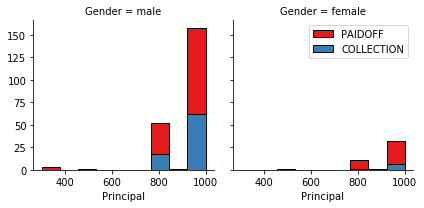

In [20]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

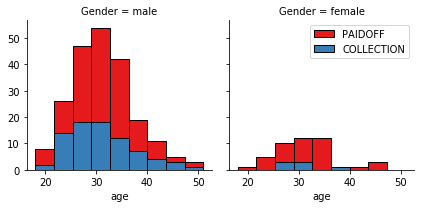

In [21]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

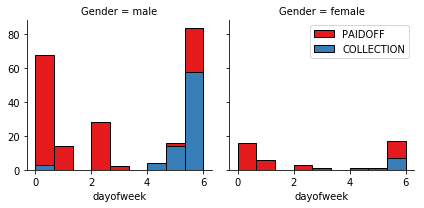

In [22]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [23]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [24]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [25]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [26]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [27]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [28]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [29]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [30]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [31]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [32]:
print(X.size//8, y.size)

346 346


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
Train set Accuracy:  0.800724637681
Test set Accuracy:  0.714285714286


In [56]:

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
   
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
print('')
print('The best k to build the model with the best accuracy is: k=', mean_acc.argmax()+1)

[ 0.67142857  0.65714286  0.71428571  0.68571429  0.75714286  0.71428571
  0.78571429  0.75714286  0.75714286]

The best k to build the model with the best accuracy is: k= 7


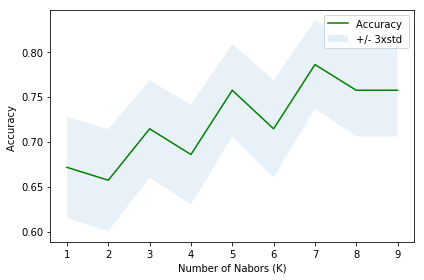

In [46]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# Decision Tree

In [63]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [76]:
Ks = 6
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):

    dTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    dTree.fit(X_train,y_train)
    pTree = dTree.predict(X_test)   

    mean_acc[n-1] = metrics.accuracy_score(y_test, pTree)
    std_acc[n-1]=np.std(pTree==y_test)/np.sqrt(pTree.shape[0])

print(mean_acc)
print('')
print('The best k to build the model with the best accuracy is: k=', mean_acc.argmax()+1)

k=mean_acc.argmax()+1

drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = k)
drugTree.fit(X_train,y_train)
predTree = drugTree.predict(X_test)

#print (predTree [0:5])
#print (y_test [0:5])

import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))




[ 0.74074074  0.74074074  0.74074074  0.77777778  0.72222222]

The best k to build the model with the best accuracy is: k= 4
DecisionTrees's Accuracy:  0.777777777778


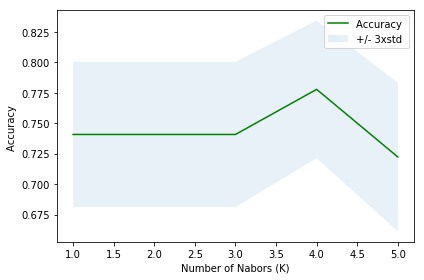

In [77]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# Support Vector Machine

In [91]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm

%matplotlib inline 
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [92]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

yhat = clf.predict(X_test)
yhat [0:5]


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

             precision    recall  f1-score   support

 COLLECTION       0.42      0.30      0.35        27
    PAIDOFF       0.78      0.86      0.81        77

avg / total       0.68      0.71      0.69       104

Confusion matrix, without normalization
[[66 11]
 [19  8]]


0.69357735662083486

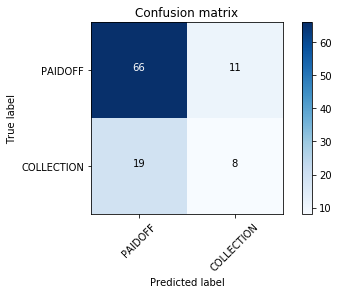

In [93]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

# Logistic Regression

In [122]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statistics import mean

%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)



Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [145]:
mean_acc = list()
stype=list()

for solvertype in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    print(solvertype)

    LR = LogisticRegression(C=0.01, solver=solvertype).fit(X_train,y_train)
    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
        
    print("f1score:", f1_score(y_test, yhat, average='weighted'))
    print('jaccard:', jaccard_similarity_score(y_test, yhat))
    print('logloss:', log_loss(y_test, yhat_prob))
    
    score=mean([f1_score(y_test, yhat, average='weighted'), jaccard_similarity_score(y_test, yhat), log_loss(y_test, yhat_prob)])
    print(score)
    mean_acc.append(score)
    stype.append(solvertype)
    
print(stype, mean_acc)

max_value = max(mean_acc)
max_index = mean_acc.index(max_value)
print('')
print('The best solver is: ',stype[max_index])
print('The best average score is: ', mean_acc[max_index])

newton-cg
f1score: 0.630417651694
jaccard: 0.740740740741
logloss: 0.515360539128
0.628839643854
lbfgs
f1score: 0.630417651694
jaccard: 0.740740740741
logloss: 0.51536073807
0.628839710168
liblinear
f1score: 0.630417651694
jaccard: 0.740740740741
logloss: 0.556608494631
0.642588962355
sag
f1score: 0.630417651694
jaccard: 0.740740740741
logloss: 0.515361041448
0.628839811294
saga
f1score: 0.630417651694
jaccard: 0.740740740741
logloss: 0.515366008142
0.628841466859
['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] [0.62883964385441382, 0.62883971016830187, 0.64258896235530294, 0.62883981129442013, 0.62884146685892983]

The best solver is:  liblinear
The best average score is:  0.642588962355


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-05-30 02:37:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-05-30 02:37:35 (592 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [140]:
## load training data  ##
df = pd.read_csv('loan_train.csv')
print(df.head())
print(df.shape)

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
print(df.head())
df['loan_status'].value_counts()

df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
print(df.head())

df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
print('df size', df.shape)
print(df.head())

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
print('this is Feature', Feature.shape)

X = Feature
X[0:5]

y = df['loan_status'].values
print(y)

X= preprocessing.StandardScaler().fit(X).transform(X)
print(X)

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male  
(346, 10)
   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2    

In [141]:
## lead test data  ##
test_df = pd.read_csv('loan_test.csv')
print(test_df.head())
print(test_df.shape)

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
print(test_df.head())
test_df['loan_status'].value_counts()

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
print(test_df.head())

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
print('test_df size', test_df.shape)
print(test_df.head())

tFeature = test_df[['Principal','terms','age','Gender','weekend']]
tFeature = pd.concat([tFeature,pd.get_dummies(test_df['education'])], axis=1)
tFeature.drop(['Master or Above'], axis = 1,inplace=True)
tFeature.head()
print('this is tFeature', tFeature.shape)

tX = tFeature
tX[0:5]

ty = test_df['loan_status'].values
print(ty)

tX= preprocessing.StandardScaler().fit(tX).transform(tX)
print(tX)

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male  
(54, 10)
   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAIDOFF        300      7     2016-09-09   
2     

In [143]:
### Evaluation for K Nearest Neighbor(KNN)
### Training set is loan_train.csv, testing set is loan_test.csv

X_train=X
y_train=y

X_test=tX
y_test=ty

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)



Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
   
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
print('')
print('The best k to build the model with the best accuracy is: k=', mean_acc.argmax()+1)

k = mean_acc.argmax()+1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

from sklearn.metrics import f1_score
print('KNN f1_score:', f1_score(y_test, yhat, average='weighted'))

from sklearn.metrics import jaccard_similarity_score
print('KNN Jaccard score:', jaccard_similarity_score(y_test, yhat))

Train set: (346, 8) (346,)
Test set: (54, 8) (54,)
[ 0.7   0.57  0.65  0.63  0.74  0.69  0.72  0.7   0.7 ]

The best k to build the model with the best accuracy is: k= 5
Train set Accuracy:  0.815028901734
Test set Accuracy:  0.740740740741
KNN f1_score: 0.725308641975
KNN Jaccard score: 0.740740740741


In [144]:
### Evaluation for Decision Tree
### Training set is loan_train.csv, testing set is loan_test.csv

from sklearn.tree import DecisionTreeClassifier

X_train=X
y_train=y

X_test=tX
y_test=ty

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Ks = 6
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):

    dTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    dTree.fit(X_train,y_train)
    pTree = dTree.predict(X_test)   

    mean_acc[n-1] = metrics.accuracy_score(y_test, pTree)
    std_acc[n-1]=np.std(pTree==y_test)/np.sqrt(pTree.shape[0])

print(mean_acc)
print('')
print('The best k to build the model with the best accuracy is: k=', mean_acc.argmax()+1)

k=mean_acc.argmax()+1

dTree = DecisionTreeClassifier(criterion="entropy", max_depth = k)
dTree.fit(X_train,y_train)
pTree = dTree.predict(X_test)

#print (predTree [0:5])
#print (y_test [0:5])

import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, pTree))

from sklearn.metrics import f1_score
print('DecisionTrees f1_score:', f1_score(y_test, pTree, average='weighted'))

from sklearn.metrics import jaccard_similarity_score
print('DecisionTrees Jaccard score:', jaccard_similarity_score(y_test, pTree))


Train set: (346, 8) (346,)
Test set: (54, 8) (54,)
[ 0.74  0.74  0.74  0.78  0.72]

The best k to build the model with the best accuracy is: k= 4
DecisionTrees's Accuracy:  0.777777777778
DecisionTrees f1_score: 0.728395061728
DecisionTrees Jaccard score: 0.777777777778


Train set: (346, 8) (346,)
Test set: (54, 8) (54,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        14
    PAIDOFF       0.74      0.97      0.84        40

avg / total       0.55      0.72      0.62        54

Confusion matrix, without normalization
[[39  1]
 [14  0]]
SVM f1_score: 0.621266427718
SVM Jaccard score: 0.722222222222


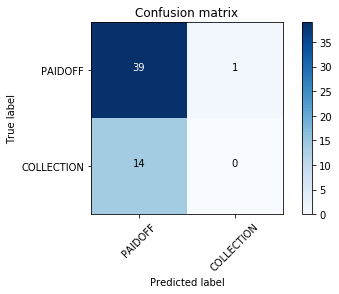

In [142]:
### Evaluation for SVM
### Training set is loan_train.csv, testing set is loan_test.csv

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

X_train=X
y_train=y

X_test=tX
y_test=ty

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

yhat = clf.predict(X_test)
print(yhat)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

from sklearn.metrics import f1_score
print('SVM f1_score:', f1_score(y_test, yhat, average='weighted'))

from sklearn.metrics import jaccard_similarity_score
print('SVM Jaccard score:', jaccard_similarity_score(y_test, yhat))

In [146]:
### Evaluation for Logistic Regression
### Training set is loan_train.csv, testing set is loan_test.csv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import itertools

X_train=X
y_train=y

X_test=tX
y_test=ty

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

yhat = LR.predict(X_test)
print (yhat)
yhat_prob = LR.predict_proba(X_test)

#from sklearn.metrics import f1_score
print('LR f1_score:', f1_score(y_test, yhat, average='weighted'))

from sklearn.metrics import jaccard_similarity_score
print('LR Jaccard score:', jaccard_similarity_score(y_test, yhat))

from sklearn.metrics import log_loss
print('LR log_loss score:', log_loss(y_test, yhat_prob))

Train set: (346, 8) (346,)
Test set: (54, 8) (54,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
LR f1_score: 0.630417651694
LR Jaccard score: 0.740740740741
LR log_loss score: 0.556608494631


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.741   | 0.725    | NA      |
| Decision Tree      | 0.778   | 0.728    | NA      |
| SVM                | 0.722   | 0.621    | NA      |
| LogisticRegression | 0.740   | 0.630    | 0.556   |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>